In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TTT Gradient Analysis

Comparing surrogate vs non-surrogate gradients for k, q, v inputs.

In [42]:
import jax
import jax.numpy as jnp
from flax import nnx
from flax.nnx import rnglib as rng
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '../../..')

from ueaj.model.ttt import TTTModel
from ueaj.model import GMLP, Einsum, lecun_normal_init

In [43]:
# Config
model_d, hidden_d = 64, 128
batch_size, seq_len = 4, 1024
seed = 42

In [44]:
# Create models
model_surr = TTTModel(model_d, hidden_d, GMLP.override(down_proj=Einsum.override(initializer=lecun_normal_init)), surrogate=True, rngs=rng.Rngs(seed))
model_nonsurr = TTTModel(model_d, hidden_d, GMLP.override(down_proj=Einsum.override(initializer=lecun_normal_init)), surrogate=False, rngs=rng.Rngs(seed))

# Generate k, q, v directly
key = jax.random.PRNGKey(123)
k_key, v_key, q_key = jax.random.split(key, 3)
k = jax.random.normal(k_key, (batch_size, seq_len, hidden_d))
v = jax.random.normal(v_key, (batch_size, seq_len, hidden_d))
q = jax.random.normal(q_key, (batch_size, seq_len, hidden_d))

print(f"k, v, q shapes: {k.shape}")

k, v, q shapes: (4, 1024, 128)


In [45]:
def compute_grads(model, k, v, q, grad_output):
    """Compute gradients w.r.t. k, v, q using VJP."""
    def forward(k, v, q):
        return model.apply_ttt(k, v, q)
    
    output, vjp_fn = jax.vjp(forward, k, v, q)
    grad_k, grad_v, grad_q = vjp_fn(grad_output)
    return grad_k, grad_v, grad_q, output

def rms_error_per_token(grad_surr, grad_nonsurr):
    """Compute RMS error per token position, averaged over batch."""
    diff = grad_surr - grad_nonsurr
    rms_per_batch = jnp.sqrt(jnp.mean(diff**2, axis=2))  # (batch, seq_len)
    return rms_per_batch.mean(axis=0)  # (seq_len,)

def rms_norm_per_token(grad):
    """Compute RMS norm per token position, averaged over batch."""
    rms_per_batch = jnp.sqrt(jnp.mean(grad**2, axis=2))  # (batch, seq_len)
    return rms_per_batch.mean(axis=0)  # (seq_len,)

In [46]:
# Random output gradient
grad_output = jax.random.normal(jax.random.PRNGKey(456), (batch_size, seq_len, hidden_d))

# Compute gradients
print("Computing gradients...")
gk_surr, gv_surr, gq_surr, _ = compute_grads(model_surr, k, v, q, grad_output)
gk_nonsurr, gv_nonsurr, gq_nonsurr, _ = compute_grads(model_nonsurr, k, v, q, grad_output)
print("✓ Done")

Computing gradients...
Start of state State({
  'down_proj': {
    'w': VariableState( # 65,536 (131.1 KB)
      type=Param,
      value=Array([[0.060791, -0.0308838, -0.0854492, ..., -0.0402832, -0.0854492,
              0.0844727],
             [0.0284424, 0.0751953, -0.0366211, ..., 0.0124512, 0.0568848,
              -0.0180664],
             [0.0588379, 0.0727539, -0.0395508, ..., 0.00494385, -0.0142212,
              -0.0289307],
             ...,
             [-0.0223389, 0.00543213, -0.0296631, ..., 0.0446777, -0.0253906,
              -0.0114136],
             [0.0588379, -0.0234375, -0.0588379, ..., -0.100098, 0.0159912,
              0.00939941],
             [0.0727539, 0.0476074, 0.00842285, ..., 0.0507812, -0.010437,
              -0.0649414]], dtype=bfloat16)
    )
  },
  'fused_proj': {
    'w': VariableState( # 131,072 (262.1 KB)
      type=Param,
      value=Array([[[0.0490723, -0.0957031, 0.0373535, ..., 0.0864258, -0.0507812,
               0.132812],
              

In [47]:
# Compute RMS errors and norms per token
rms_k = rms_error_per_token(gk_surr, gk_nonsurr)
rms_v = rms_error_per_token(gv_surr, gv_nonsurr)
rms_q = rms_error_per_token(gq_surr, gq_nonsurr)

norm_k = rms_norm_per_token(gk_nonsurr)
norm_v = rms_norm_per_token(gv_nonsurr)
norm_q = rms_norm_per_token(gq_nonsurr)

print(f"RMS error ranges:")
print(f"  k: [{rms_k.min():.4f}, {rms_k.max():.4f}]")
print(f"  v: [{rms_v.min():.4f}, {rms_v.max():.4f}]")
print(f"  q: [{rms_q.min():.4f}, {rms_q.max():.4f}]")

RMS error ranges:
  k: [0.9770, 62.2160]
  v: [0.5619, 38.9429]
  q: [0.0000, 0.9146]


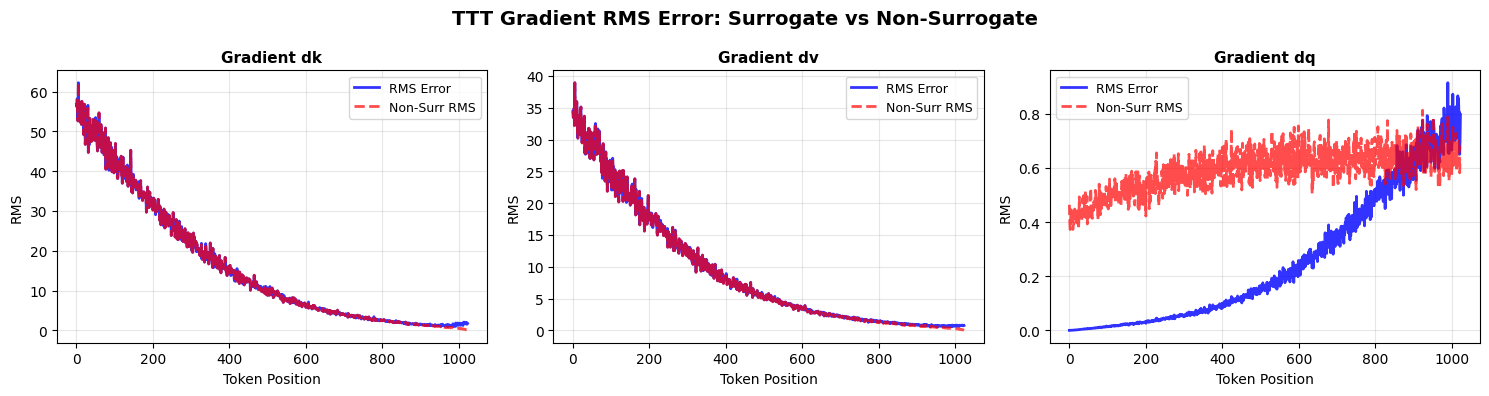

✓ Saved as 'ttt_gradient_comparison.png'


In [48]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('TTT Gradient RMS Error: Surrogate vs Non-Surrogate', fontsize=14, fontweight='bold')

tokens = np.arange(seq_len)

for ax, rms, norm, name in zip(axes, [rms_k, rms_v, rms_q], [norm_k, norm_v, norm_q], ['k', 'v', 'q']):
    ax.plot(tokens, rms, 'b-', linewidth=2, label='RMS Error', alpha=0.8)
    ax.plot(tokens, norm, 'r--', linewidth=2, label='Non-Surr RMS', alpha=0.7)
    ax.set_xlabel('Token Position', fontsize=10)
    ax.set_ylabel('RMS', fontsize=10)
    ax.set_title(f'Gradient d{name}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ttt_gradient_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved as 'ttt_gradient_comparison.png'")